# Finding and Predicting City regions via clustering.

### A description of the problem and a discussion of the background.

City region is a term in use since about 1950 by urbanists, economists and urban planners to mean a metropolitan area and hinterland, often having a shared administration.<br> 
Administrative city divisions often do not reflect the actual condition of different areas of the city. Of course, the division of a city into regions can be carried out according to various criteria. Therefore, the division should be performed depending on the set administrative or business tasks. The actual boundaries of urban regions may change over time due to the intensity of activity in and around certain points. Assessing and predicting such points could play an important role in city and business planning.

__Problem__<br>
Data that can contribute to the regional division of cities can include city venues. Such data can be accessed using the Foursquare API. The aim of this project is to cluster regions of Moscow using metro stations as reference points and on the basis of the results to predict the the regional division of other cities.


In [1]:
# impotr libraries

import pandas as pd
import numpy as np
import requests
import folium
from geopy.geocoders import Nominatim


from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup

__Scraping Moscow metro stations and coordinates__

In [2]:
# URL page "List of Moscow metro stations"
moscow_url = "http://www.lovrikinfo.ru/metrogps.php"

In [3]:
s = requests.Session()
response = s.get(moscow_url, timeout = 10)
response

<Response [200]>

In [4]:
# parse response content to html
soup = BeautifulSoup(response.content, 'html.parser')

In [5]:
moscow_table = soup.findAll('table', {"border":"0", "width":"510"}) # Grab the table

In [6]:
# Number of columns in the table
for row in moscow_table[0].findAll("tr"):
    cells = row.findAll('td')

len(cells)

3

In [7]:
# number of rows in the table including header
moscow_rows = moscow_table[0].findAll("tr")
len(moscow_rows)

165

In [8]:
#get tabular data
moscow_lst_data = []
for row in moscow_rows[1:]:
            data = [d.text.rstrip() for d in row.find_all('td')]
            moscow_lst_data.append(data)

In [9]:
# sample records
moscow_lst_data[0:3]

[['Академическая', '55.68808', '37.57501'],
 ['Алексеевская', '55.80737', '37.63844'],
 ['Александровский сад', '55.75219', '37.60836']]

In [10]:
# create pandas dataframe
moscow_metro_df = pd.DataFrame(moscow_lst_data, columns = ['Station','Latitude','Longitude'])

In [12]:
moscow_metro_df.head()

,Station,Latitude,Longitude
0,Академическая,55.68808,37.57501
1,Алексеевская,55.80737,37.63844
2,Александровский сад,55.75219,37.60836
3,Алтуфьево,55.89504,37.58605
4,Аннино (стр.),55.581818,37.594978


In [13]:
moscow_metro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Station    164 non-null    object
 1   Latitude   164 non-null    object
 2   Longitude  164 non-null    object
dtypes: object(3)
memory usage: 4.0+ KB


In [14]:
# convert object type columns into float type
moscow_metro_df['Latitude'] = moscow_metro_df['Latitude'].astype(float)
moscow_metro_df['Longitude'] = moscow_metro_df['Longitude'].astype(float)

In [15]:
moscow_metro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Station    164 non-null    object 
 1   Latitude   164 non-null    float64
 2   Longitude  164 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.0+ KB


In [16]:
address = 'Moscow'

geolocator = Nominatim(user_agent="ny_explorer")
moscow_location = geolocator.geocode(address)
moscow_latitude = moscow_location.latitude
moscow_longitude = moscow_location.longitude
print('The geograpical coordinate of Moscow are {}, {}.'.format(moscow_latitude, moscow_longitude))

The geograpical coordinate of Moscow are 55.7504461, 37.6174943.


In [17]:
# create map of Moscow using latitude and longitude values
map_moscow = folium.Map(location=[moscow_latitude, moscow_longitude], zoom_start=10)

# add markers to map
for lat, lng, station in zip(moscow_metro_df['Latitude'], moscow_metro_df['Longitude'], moscow_metro_df['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

__Scraping St.Petersburg metro stations and coordinates__

In [18]:
# URL page "List of St.Petersburg metro stations"
spb_url = "http://quantron-systems.com/ru/article/89"

In [19]:
s = requests.Session()
response = s.get(spb_url, timeout = 10)
response

<Response [200]>

In [20]:
# parse response content to html
soup = BeautifulSoup(response.content, 'html.parser')

In [21]:
spb_table = soup.findAll('table', {"class":"table"}) # Grab the table

In [22]:
# Number of columns in the table
for row in spb_table[0].findAll("tr"):
    cells = row.findAll('td')

len(cells)

3

In [23]:
# number of rows in the table including header
spb_rows = spb_table[0].findAll("tr")
len(spb_rows)

87

In [24]:
#get tabular data
spb_lst_data = []
for row in spb_rows[1:]:
    #print(row)
    data = [d.text.rstrip() for d in row.find_all('div')]
    #print(data)
    spb_lst_data.append(data)

In [25]:
# sample records
spb_lst_data[0:3]

[['\r\n                    Вестибюль станции',
  '\r\n                    Широта',
  '\r\n                    Долгота'],
 ['\r\n                    Проспект Ветеранов',
  '\r\n                    59.84188',
  '\r\n                    30.251543'],
 ['\r\n                    Ленинский проспект',
  '\r\n                    59.851677',
  '\r\n                    30.268279']]

In [26]:
# remove unnecessary chars from our data
spb_stations_list = []
for row in spb_lst_data:
    temp = []
    a = str(row[0]).replace('\r\n                    ', '')
    try:
        b = str(row[1]).replace('\r\n                    ', '')
        c = str(row[2]).replace('\r\n                    ', '')
    except IndexError:
        continue
    temp.append(a)
    temp.append(b)
    temp.append(c)
    spb_stations_list.append(temp)

In [27]:
# create pandas dataframe
spb_metro_df = pd.DataFrame(spb_stations_list, columns = ['Station','Latitude','Longitude'])

In [28]:
spb_metro_df

,Station,Latitude,Longitude
0,Вестибюль станции,Широта,Долгота
1,Проспект Ветеранов,59.84188,30.251543
2,Ленинский проспект,59.851677,30.268279
3,Автово,59.867369,30.261345
4,Кировский завод,59.879726,30.261908
...,...,...,...
77,Ладожский вокзал,59.931109,30.439826
78,Московский вокзал,59.929159,30.360055
79,Финляндский вокзал,59.955982,30.355729
80,Аэропорт,Широта,Долгота


In [29]:
spb_metro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Station    82 non-null     object
 1   Latitude   82 non-null     object
 2   Longitude  82 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


In [30]:
# some records do not contain coordinates. Let's delete them.
spb_metro_df.drop([0, 20, 39, 50, 59, 74, 80], inplace=True)

In [31]:
# convert object type columns into float type
spb_metro_df['Latitude'] = spb_metro_df['Latitude'].astype(float)
spb_metro_df['Longitude'] = spb_metro_df['Longitude'].astype(float)

In [32]:
spb_metro_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 1 to 81
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Station    75 non-null     object 
 1   Latitude   75 non-null     float64
 2   Longitude  75 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.3+ KB


In [33]:
address = 'Saint Petersburg'

geolocator = Nominatim(user_agent="ny_explorer")
spb_location = geolocator.geocode(address)
spb_latitude = spb_location.latitude
spb_longitude = spb_location.longitude
print('The geograpical coordinate of Saint Petersburg are {}, {}.'.format(spb_latitude, spb_longitude))

The geograpical coordinate of Saint Petersburg are 59.938732, 30.316229.


In [34]:
# create map of Saint Petersburg using latitude and longitude values
map_spb = folium.Map(location=[spb_latitude, spb_longitude], zoom_start=10)

# add markers to map
for lat, lng, station in zip(spb_metro_df['Latitude'], spb_metro_df['Longitude'], spb_metro_df['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_spb)  
    
map_spb

__Saving dataframes to pickle__

In [35]:
#moscow_metro_df.to_pickle('moscow_metro_df.pkl')

In [36]:
#spb_metro_df.to_pickle('spb_metro_df.pkl')

In [37]:
#moscow_metro_df = pd.read_pickle('moscow_metro_df.pkl')

In [38]:
#spb_metro_df = pd.read_pickle('spb_metro_df.pkl')

__Define Foursquare Credentials and Version__

In [39]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    '''
    Returns the dataframe of the objects in the area of a certain station
    
    Parameters:
    names: string - object name
    latitudes, longitudes: float -  latitude and longitude of the object
    radius: int - radius in meters
    
    Return:
    nearby_venues - dataframe of objects and corresponding venues
    
    '''
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'])for v in results])
            #v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
                  #'Venue id']
    
    return(nearby_venues)

__Let's get the venues that are around Moscow metro stations within a radius of 1000 meters.__

Due to the fact that when obtaining a large amount of data using Forsquare API often error, I had to repeat this operation several times. The data are saved in pickle format.

In [ ]:
moscow_venues_temp = getNearbyVenues(names=moscow_metro_df['Station'],
                                   latitudes=moscow_metro_df['Latitude'],
                                   longitudes=moscow_metro_df['Longitude']
                                  )

In [ ]:
#moscow_venues = moscow_venues_temp.copy()

In [ ]:
#moscow_venues = pd.concat([moscow_venues, moscow_venues_temp])

In [41]:
#moscow_venues.to_pickle('moscow_venues.pkl')
moscow_venues = pd.read_pickle('moscow_venues.pkl')

In [42]:
moscow_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Академическая,55.68808,37.57501,Вкусвилл,55.686904,37.575196,Health Food Store
1,Академическая,55.68808,37.57501,Здоров.ру,55.687911,37.571558,Pharmacy
2,Академическая,55.68808,37.57501,Billy McDaniel,55.688104,37.571608,Pub
3,Академическая,55.68808,37.57501,Академический парк,55.691777,37.568886,Park
4,Академическая,55.68808,37.57501,HobbyGames,55.688509,37.570087,Toy / Game Store


In [43]:
moscow_venues.shape

(12488, 7)

__How many venues were returned for each station__

In [44]:
moscow_venues.groupby('Station').count()

,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Station,,,,,,
Cавеловская,96,96,96,96,96,96
Cвиблово,58,58,58,58,58,58
Cевастопольская,75,75,75,75,75,75
Cеменовская,100,100,100,100,100,100
Cерпуховская,100,100,100,100,100,100
...,...,...,...,...,...,...
Щукинская,57,57,57,57,57,57
Электрозаводская,88,88,88,88,88,88
Юго-западная,74,74,74,74,74,74


__Let's find out how many unique categories can be curated from all the returned venues__

In [45]:
print('There are {} uniques categories.'.format(len(moscow_venues['Venue Category'].unique())))

There are 412 uniques categories.


In [46]:
# one hot encoding
moscow_onehot = pd.get_dummies(moscow_venues[['Venue Category']], prefix="", prefix_sep="")

In [47]:
# add station column back to dataframe
moscow_onehot['Station'] = moscow_venues['Station'] 

In [48]:
moscow_onehot.head()

,Accessories Store,Adult Boutique,Advertising Agency,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Armenian Restaurant,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Station
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Академическая
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Академическая
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Академическая
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Академическая
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Академическая


In [49]:
moscow_onehot.shape

(12488, 413)

__Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category__

In [50]:
moscow_grouped = moscow_onehot.groupby('Station').mean().reset_index()
moscow_grouped.head()

,Station,Accessories Store,Adult Boutique,Advertising Agency,American Restaurant,Amphitheater,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Cавеловская,0.0,0.0,0.0,0.000000,0.0,0.0,0.010417,0.0,0.0,...,0.0,0.0,0.0,0.00,0.010417,0.010417,0.010417,0.010417,0.0,0.0
1,Cвиблово,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.000000,0.000000,0.017241,0.000000,0.0,0.0
2,Cевастопольская,0.0,0.0,0.0,0.013333,0.0,0.0,0.026667,0.0,0.0,...,0.0,0.0,0.0,0.00,0.013333,0.000000,0.000000,0.000000,0.0,0.0
3,Cеменовская,0.0,0.0,0.0,0.000000,0.0,0.0,0.020000,0.0,0.0,...,0.0,0.0,0.0,0.00,0.010000,0.000000,0.010000,0.010000,0.0,0.0
4,Cерпуховская,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.01,0.010000,0.000000,0.000000,0.040000,0.0,0.0


In [51]:
moscow_grouped.shape

(162, 413)

In [52]:
#sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
moscow_stations_venues_sorted = pd.DataFrame(columns=columns)
moscow_stations_venues_sorted['Station'] = moscow_grouped['Station']

for ind in np.arange(moscow_grouped.shape[0]):
    moscow_stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(moscow_grouped.iloc[ind, :], num_top_venues)

moscow_stations_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Cавеловская,Coffee Shop,Gym / Fitness Center,Dance Studio,Electronics Store,Photography Studio
1,Cвиблово,Cosmetics Shop,Pizza Place,Food & Drink Shop,Gym,Gym / Fitness Center
2,Cевастопольская,Gym / Fitness Center,Clothing Store,Fast Food Restaurant,Health Food Store,Pizza Place
3,Cеменовская,Coffee Shop,Photography Studio,Pet Store,Dance Studio,Hobby Shop
4,Cерпуховская,Coffee Shop,Bakery,Yoga Studio,Cosmetics Shop,Spa


In [54]:
moscow_stations_venues_sorted.shape

(162, 6)

In [55]:
moscow_grouped_clustering = moscow_grouped.drop('Station', 1)

__To find the optimal number of clusters, we use the elbow method.__

In [56]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(moscow_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

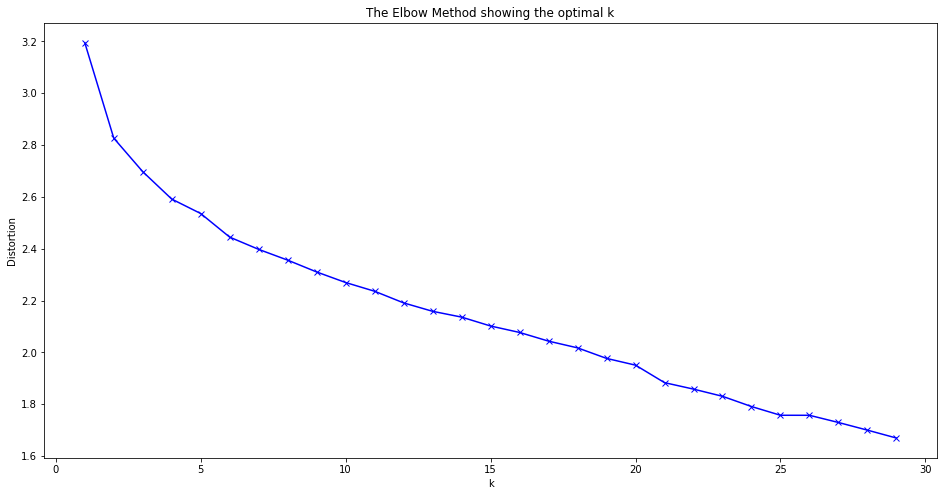

In [57]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method does not allow you to determine the optimal number of clusters

__Let's try hierarchical clustering__

In [58]:
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster

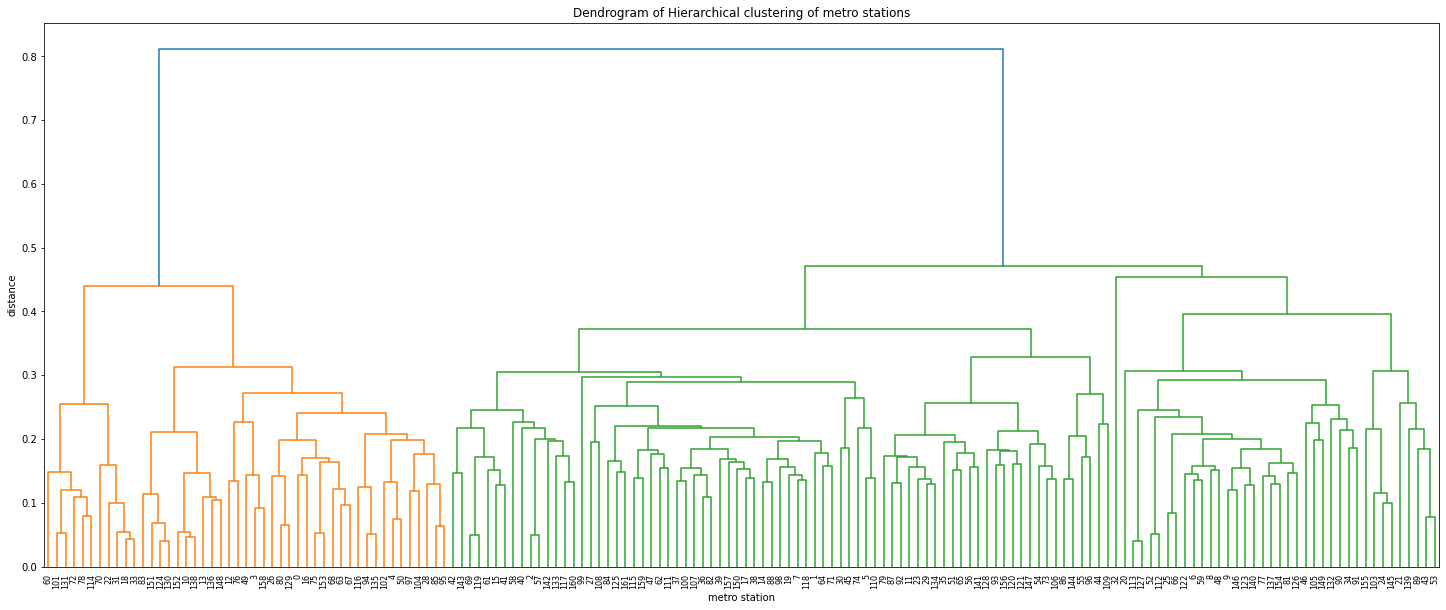

In [59]:
Z = hac.linkage(moscow_grouped_clustering[moscow_grouped_clustering.sum(axis=1) > 0], method='ward', metric='euclidean')

# Отображение дендрограммы
plt.figure(figsize=(25, 10))
plt.title('Dendrogram of Hierarchical clustering of metro stations')
plt.xlabel('metro station')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Still difficult to determine the optimal number of clusters, after several experiments it was decided to choose 3 clusters. 

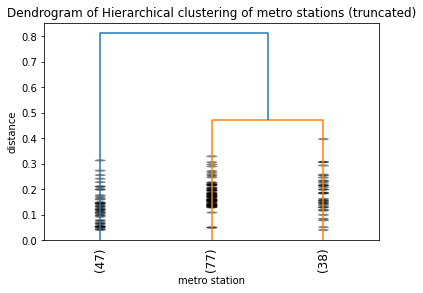

In [60]:
plt.title('Dendrogram of Hierarchical clustering of metro stations (truncated)')
plt.xlabel('metro station')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last merged p clusters
    p=3,
    show_leaf_counts=True,  # number of leaves in the branch
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # show the distribution in the cut branches
)
plt.show()

### Cluster metro stations

__Run k-means to cluster the neighborhood into 3 clusters__

In [61]:
# set number of clusters
kclusters = 3

moscow_grouped_clustering = moscow_grouped.drop('Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 0, 1, 1, 0, 1, 2, 2, 1], dtype=int32)

__Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood__

In [62]:
# add clustering labels
moscow_stations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

moscow_merged = moscow_metro_df

In [63]:
moscow_merged.columns=['Station', 'Latitude', 'Longitude']

# merge moscow_grouped with moscow_data to add latitude/longitude for each station
moscow_merged = moscow_merged.join(moscow_stations_venues_sorted.set_index('Station'), on='Station')

moscow_merged.head() # check the last columns!

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Академическая,55.688080,37.575010,0,Park,Pharmacy,Sushi Restaurant,Supermarket,Health Food Store
1,Алексеевская,55.807370,37.638440,2,Electronics Store,Auto Workshop,Coffee Shop,Hobby Shop,Mobile Phone Shop
2,Александровский сад,55.752190,37.608360,1,Plaza,Coffee Shop,Boutique,Cocktail Bar,History Museum
3,Алтуфьево,55.895040,37.586050,0,Health Food Store,Gym / Fitness Center,Pizza Place,Bar,Salon / Barbershop
4,Аннино (стр.),55.581818,37.594978,2,Auto Workshop,Historic Site,Go Kart Track,Pedestrian Plaza,Shoe Store


__Visualize the resulting clusters__

In [64]:
# create map
moscow_map_clusters = folium.Map(location=[moscow_latitude, moscow_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

In [65]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(moscow_merged['Latitude'], moscow_merged['Longitude'], moscow_merged['Station'], moscow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(moscow_map_clusters)
       
moscow_map_clusters

__Let's see the top 10 objects in each cluster__

In [66]:
asd = moscow_grouped_clustering.copy()

In [67]:
asd.insert(0, 'Cluster Labels', kmeans.labels_)
asd = asd.groupby('Cluster Labels').mean()
asd.reset_index(inplace=True)

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
moscow_clusters_venues = pd.DataFrame(columns=columns)
moscow_clusters_venues['Cluster Labels'] = asd['Cluster Labels']

In [72]:
for ind in np.arange(asd.shape[0]):
    moscow_clusters_venues.iloc[ind, 1:] = return_most_common_venues(asd.iloc[ind, :], num_top_venues)

moscow_clusters_venues

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Supermarket,Park,Gym / Fitness Center,Health Food Store,Pizza Place,Cosmetics Shop,Pharmacy,Café,Coffee Shop,Sushi Restaurant
1,1,Coffee Shop,Theater,Gym / Fitness Center,Hotel,Dance Studio,Café,Yoga Studio,Caucasian Restaurant,Plaza,Bakery
2,2,Coffee Shop,Café,Auto Workshop,Gym / Fitness Center,Electronics Store,Clothing Store,Park,Supermarket,Cosmetics Shop,Sporting Goods Shop


__Let's get venues that are around St.Petersburg metro stations within a radius of 1000 meters.__

In [ ]:
spb_venues = getNearbyVenues(names=spb_metro_df['Station'],
                                   latitudes=spb_metro_df['Latitude'],
                                   longitudes=spb_metro_df['Longitude']
                                  )

In [73]:
#spb_venues.to_pickle('spb_venues.pkl')
spb_venues = pd.read_pickle('spb_venues.pkl')

In [74]:
spb_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Проспект Ветеранов,59.84188,30.251543,Mr. Black,59.842507,30.247521,Coffee Shop
1,Проспект Ветеранов,59.84188,30.251543,Токио-City,59.842388,30.255064,Japanese Restaurant
2,Проспект Ветеранов,59.84188,30.251543,Амфория,59.836435,30.246095,Spa
3,Проспект Ветеранов,59.84188,30.251543,Святогор,59.841328,30.252632,Gym / Fitness Center
4,Проспект Ветеранов,59.84188,30.251543,Батончик,59.840928,30.257903,Bakery


In [75]:
spb_venues.shape

(5927, 7)

In [76]:
print('There are {} uniques categories.'.format(len(spb_venues['Venue Category'].unique())))

There are 353 uniques categories.


In [77]:
# one hot encoding
spb_onehot = pd.get_dummies(spb_venues[['Venue Category']], prefix="", prefix_sep="")

In [78]:
# add station column back to dataframe
spb_onehot['Station'] = spb_venues['Station'] 

In [79]:
spb_onehot.head()

,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Station
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Проспект Ветеранов
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Проспект Ветеранов
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Проспект Ветеранов
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Проспект Ветеранов
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Проспект Ветеранов


In [80]:
spb_onehot.shape

(5927, 354)

In [81]:
spb_grouped = spb_onehot.groupby('Station').mean().reset_index()
spb_grouped.head()

,Station,ATM,Accessories Store,Adult Boutique,Advertising Agency,Airport,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,...,Warehouse Store,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Автово,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.036364,0.000000,0.000000,0.0,0.0
1,Адмиралтейская,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.02,0.000000,0.000000,0.000000,0.0,0.0
2,Академическая,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015152,0.0,0.0,0.0,0.00,0.015152,0.015152,0.000000,0.0,0.0
3,Балтийская,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.012658,0.012658,0.012658,0.0,0.0
4,Балтийский вокзал,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.012346,0.012346,0.012346,0.0,0.0


In [82]:
spb_grouped.shape

(74, 354)

In [83]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
spb_stations_venues_sorted = pd.DataFrame(columns=columns)
spb_stations_venues_sorted['Station'] = spb_grouped['Station']

for ind in np.arange(spb_grouped.shape[0]):
    spb_stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(spb_grouped.iloc[ind, :], num_top_venues)

spb_stations_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Автово,Bakery,Auto Workshop,Bus Stop,Café,Cafeteria,Convenience Store,Supplement Shop,Wine Shop,Hookah Bar,Mobile Phone Shop
1,Адмиралтейская,Hotel,Coffee Shop,Bar,Restaurant,Italian Restaurant,Plaza,Art Museum,Hookah Bar,Hostel,Music Venue
2,Академическая,Bakery,Soccer Field,Gym / Fitness Center,Playground,Cosmetics Shop,Gastropub,Pizza Place,Dance Studio,Pet Store,Sporting Goods Shop
3,Балтийская,Photography Studio,Coffee Shop,Bakery,Hotel,Recording Studio,Escape Room,Tailor Shop,Auto Workshop,Music Venue,Arts & Crafts Store
4,Балтийский вокзал,Photography Studio,Coffee Shop,Bakery,Hotel,Gym,Recording Studio,Dance Studio,Supermarket,Tailor Shop,Theater


In [84]:
# set number of clusters
kclusters = 3

spb_grouped_clustering = spb_grouped.drop('Station', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(spb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 2, 2, 2, 1, 0, 0, 0, 1], dtype=int32)

In [85]:
# add clustering labels
spb_stations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

spb_merged = spb_metro_df

In [86]:
spb_merged.columns=['Station', 'Latitude', 'Longitude']

# merge spb_grouped with spb_data to add latitude/longitude for each station
spb_merged = spb_merged.join(spb_stations_venues_sorted.set_index('Station'), on='Station')

spb_merged.head()

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Проспект Ветеранов,59.841880,30.251543,2,Bakery,Supermarket,Doner Restaurant,Athletics & Sports,Food & Drink Shop,Farmers Market,Electronics Store,Coffee Shop,Mobile Phone Shop,Blini House
2,Ленинский проспект,59.851677,30.268279,2,Bakery,Cosmetics Shop,Café,Arts & Crafts Store,Restaurant,Supermarket,Pharmacy,Dance Studio,Boutique,Smoke Shop
3,Автово,59.867369,30.261345,2,Bakery,Auto Workshop,Bus Stop,Café,Cafeteria,Convenience Store,Supplement Shop,Wine Shop,Hookah Bar,Mobile Phone Shop
4,Кировский завод,59.879726,30.261908,1,Clothing Store,Auto Workshop,Sporting Goods Shop,Bus Stop,Café,Playground,Soccer Field,Bakery,Theater,Shawarma Place
5,Нарвская,59.901169,30.274676,2,Café,Bakery,Photography Studio,Park,Burger Joint,Concert Hall,Dance Studio,Theater,Asian Restaurant,Soccer Field


In [87]:
# create map
spb_map_clusters = folium.Map(location=[spb_latitude, spb_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(spb_merged['Latitude'], spb_merged['Longitude'], spb_merged['Station'], spb_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(spb_map_clusters)
       
spb_map_clusters

__Select common objects in Moscow and St. Petersburg__

In [88]:
common_venues = moscow_grouped.columns.intersection(spb_grouped.columns)

In [89]:
common_venues.shape

(314,)

In [90]:
moscow_common_grouped = moscow_grouped[common_venues]
spb_common_grouped = spb_grouped[common_venues]

__Re-perform the clustering of Moscow and St. Petersburg metro stations into 3 clusters, using 314 categories.__

In [97]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
moscow_common_stations_venues_sorted = pd.DataFrame(columns=columns)
moscow_common_stations_venues_sorted['Station'] = moscow_common_grouped['Station']

for ind in np.arange(moscow_grouped.shape[0]):
    moscow_common_stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(moscow_common_grouped.iloc[ind, :], num_top_venues)

In [98]:
# set number of clusters
kclusters = 3

moscow_common_grouped_clustering = moscow_common_grouped.drop('Station', 1)

# run k-means clustering
moscow_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_common_grouped_clustering)

# check cluster labels generated for each row in the dataframe
moscow_kmeans.labels_[0:10] 

array([1, 2, 0, 1, 1, 0, 1, 2, 2, 1], dtype=int32)

In [99]:
# add clustering labels
moscow_common_stations_venues_sorted.insert(0, 'Cluster Labels', moscow_kmeans.labels_)

moscow_common_merged = moscow_metro_df

In [100]:
moscow_common_merged.columns=['Station', 'Latitude', 'Longitude']

# merge moscow_grouped with moscow_data to add latitude/longitude for each station
moscow_common_merged = moscow_common_merged.join(moscow_common_stations_venues_sorted.set_index('Station'), on='Station')

In [101]:
# create map
moscow_map_clusters = folium.Map(location=[moscow_latitude, moscow_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

In [102]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(moscow_common_merged['Latitude'], moscow_common_merged['Longitude'], moscow_common_merged['Station'], moscow_common_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(moscow_map_clusters)
       
moscow_map_clusters

__Clustering St.Petersburg stations with common (314) venues__

In [107]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
spb_stations_venues_sorted = pd.DataFrame(columns=columns)
spb_stations_venues_sorted['Station'] = spb_common_grouped['Station']

for ind in np.arange(spb_grouped.shape[0]):
    spb_stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(spb_common_grouped.iloc[ind, :], num_top_venues)

#spb_stations_venues_sorted.head()

In [108]:
# set number of clusters
kclusters = 3

spb_common_grouped_clustering = spb_common_grouped.drop('Station', 1)

# run k-means clustering
spb_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(spb_common_grouped_clustering)

# check cluster labels generated for each row in the dataframe
spb_kmeans.labels_[0:10] 

array([0, 1, 0, 1, 1, 2, 1, 1, 1, 0], dtype=int32)

In [109]:
# add clustering labels
spb_stations_venues_sorted.insert(0, 'Cluster Labels', spb_kmeans.labels_)

spb_common_merged = spb_metro_df



In [110]:
spb_common_merged.columns=['Station', 'Latitude', 'Longitude']

# merge moscow_grouped with moscow_data to add latitude/longitude for each station
spb_common_merged = spb_common_merged.join(spb_stations_venues_sorted.set_index('Station'), on='Station')

#spb_common_merged.head()

In [111]:
# create map
spb_common_map_clusters = folium.Map(location=[spb_latitude, spb_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

In [112]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(spb_common_merged['Latitude'], spb_common_merged['Longitude'], spb_common_merged['Station'], spb_common_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(spb_common_map_clusters)
       
spb_common_map_clusters

__Predict clusters in St.Petersburg__

We use the k-means model derived from Moscow metro stations data to cluster St. Petersburg metro stations.

In [113]:
spb_predicted_clusters = moscow_kmeans.predict(spb_common_grouped.iloc[:,1:])

In [114]:
spb_predicted_clusters

array([2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 2, 1, 1, 1, 1, 2, 2], dtype=int32)

In [115]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
spb_predicted_stations_venues_sorted = pd.DataFrame(columns=columns)
spb_predicted_stations_venues_sorted['Station'] = spb_common_grouped['Station']

for ind in np.arange(spb_grouped.shape[0]):
    spb_predicted_stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(spb_common_grouped.iloc[ind, :], num_top_venues)

spb_predicted_stations_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Автово,Auto Workshop,Bakery,Bus Stop,Café,Supplement Shop,Wine Shop,Hookah Bar,Cafeteria,Convenience Store,Mobile Phone Shop
1,Адмиралтейская,Hotel,Coffee Shop,Restaurant,Bar,Italian Restaurant,Plaza,Hookah Bar,Hostel,Art Museum,Fountain
2,Академическая,Bakery,Gym / Fitness Center,Playground,Soccer Field,Sporting Goods Shop,Dance Studio,Gastropub,Japanese Restaurant,Cosmetics Shop,Gourmet Shop
3,Балтийская,Photography Studio,Coffee Shop,Bakery,Hotel,Recording Studio,Hookah Bar,Gym,Gym / Fitness Center,Music Venue,Auto Workshop
4,Балтийский вокзал,Photography Studio,Coffee Shop,Bakery,Gym,Hotel,Recording Studio,Arts & Crafts Store,Supermarket,Tailor Shop,Theater


In [116]:
# add clustering labels
spb_predicted_stations_venues_sorted.insert(0, 'Cluster Labels', spb_predicted_clusters)

spb_predicted_merged = spb_metro_df

In [117]:
spb_predicted_merged.columns=['Station', 'Latitude', 'Longitude']

# merge moscow_grouped with moscow_data to add latitude/longitude for each station
spb_predicted_merged = spb_predicted_merged.join(spb_predicted_stations_venues_sorted.set_index('Station'), on='Station')

spb_predicted_merged.head() # check the last columns!

,Station,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Проспект Ветеранов,59.841880,30.251543,0,Bakery,Supermarket,Pharmacy,Coffee Shop,Tennis Court,Electronics Store,Liquor Store,Blini House,Athletics & Sports,Mobile Phone Shop
2,Ленинский проспект,59.851677,30.268279,2,Bakery,Café,Cosmetics Shop,Supermarket,Boutique,Arts & Crafts Store,Pharmacy,Restaurant,Dance Studio,Smoke Shop
3,Автово,59.867369,30.261345,2,Auto Workshop,Bakery,Bus Stop,Café,Supplement Shop,Wine Shop,Hookah Bar,Cafeteria,Convenience Store,Mobile Phone Shop
4,Кировский завод,59.879726,30.261908,2,Clothing Store,Auto Workshop,Sporting Goods Shop,Playground,Bus Stop,Café,Theater,Soccer Field,Gym / Fitness Center,Shawarma Place
5,Нарвская,59.901169,30.274676,2,Café,Bakery,Photography Studio,Park,Asian Restaurant,Burger Joint,Concert Hall,Soccer Field,Auto Workshop,Bistro


In [118]:
# create map
spb_predicted_map_clusters = folium.Map(location=[spb_latitude, spb_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

In [119]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(spb_predicted_merged['Latitude'], spb_predicted_merged['Longitude'], spb_predicted_merged['Station'], spb_predicted_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(spb_predicted_map_clusters)
       
spb_predicted_map_clusters

### Accuracy calculation

__How many stations were predicted correctly?__

In [120]:
from sklearn import metrics

Since the labels of the "real" and predicted clusters do not correspond to each other, let me correct this.

In [125]:
spb_predicted_clusters[spb_predicted_clusters==2] = 123
spb_predicted_clusters[spb_predicted_clusters==0] = 2
spb_predicted_clusters[spb_predicted_clusters==123] = 0

In [126]:
spb_kmeans.labels_

array([0, 1, 0, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0], dtype=int32)

In [127]:
spb_predicted_clusters

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0], dtype=int32)

In [128]:
print("Clustering prediction Accuracy: ", metrics.accuracy_score(spb_kmeans.labels_, spb_predicted_clusters))

Clustering prediction Accuracy:  0.8783783783783784


__Conclusion__

In this work was created a clustering model, based on Foursquare data about the venues located in the area of Moscow metro stations. This model was used to cluster St. Petersburg metro stations. The resulting model can be used to determine the category of a particular point in the city.
What problems were encountered and what further ways of developing the work? First, it is not an easy task to determine the number of clusters. As hyperparameters, you can use the radius of the area in which the venues are considered (in this work 1000 meters), specific points of urban space, the selection of venues as features. Perhaps accuracy can be improved by using the venues as a feature for other machine learning methods or ensemble models. It is also possible to collect and add other features, such as population density, traffic data, property values etc.
Thus, the data from Foursquare offer great potential for zoning urban space using machine learning models.
